In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import os

In [2]:
file_path = r"C:\Code\energy-demand-forecasting\data\raw\use_all_btu.csv"

data = pd.read_csv(file_path)

In [3]:
print("First 5 rows of the dataset:")
display(data.head())

First 5 rows of the dataset:


,Data_Status,State,MSN,1960,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,2022F,AK,ABICB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.0,-2.0,-3.0,-3.0,-2.0,-14.0,-10.0,-7.0,-8.0,-6.0
1,2022F,AK,ARICB,312.0,555.0,489.0,589.0,791.0,878.0,1646.0,...,12763.0,12335.0,12450.0,12365.0,13561.0,4804.0,11973.0,12391.0,13425.0,12981.0
2,2022F,AK,ARTCB,312.0,555.0,489.0,589.0,791.0,878.0,1646.0,...,12763.0,12335.0,12450.0,12365.0,13561.0,4804.0,11973.0,12391.0,13425.0,12981.0
3,2022F,AK,ARTXB,312.0,555.0,489.0,589.0,791.0,878.0,1646.0,...,12763.0,12335.0,12450.0,12365.0,13561.0,4804.0,11973.0,12391.0,13425.0,12981.0
4,2022F,AK,AVACB,5209.0,6441.0,5202.0,3273.0,2319.0,1478.0,1086.0,...,701.0,658.0,1308.0,1240.0,1239.0,1264.0,1245.0,915.0,1037.0,1073.0


In [4]:
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14773 entries, 0 to 14772
Data columns (total 66 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Data_Status  14773 non-null  object 
 1   State        14773 non-null  object 
 2   MSN          14773 non-null  object 
 3   1960         10509 non-null  float64
 4   1961         10509 non-null  float64
 5   1962         10509 non-null  float64
 6   1963         10509 non-null  float64
 7   1964         10509 non-null  float64
 8   1965         10509 non-null  float64
 9   1966         10509 non-null  float64
 10  1967         10509 non-null  float64
 11  1968         10509 non-null  float64
 12  1969         10509 non-null  float64
 13  1970         10509 non-null  float64
 14  1971         10509 non-null  float64
 15  1972         10509 non-null  float64
 16  1973         10509 non-null  float64
 17  1974         10509 non-null  float64
 18  1975         10509 non-null  fl

In [5]:
print("\nMissing Values in Each Column:")
print(data.isnull().sum())


Missing Values in Each Column:
Data_Status       0
State             0
MSN               0
1960           4264
1961           4264
               ... 
2018              0
2019              0
2020              0
2021              0
2022              0
Length: 66, dtype: int64


In [6]:
print("\nMissing Values in Each Column:")
print(data.isnull().sum())


Missing Values in Each Column:
Data_Status       0
State             0
MSN               0
1960           4264
1961           4264
               ... 
2018              0
2019              0
2020              0
2021              0
2022              0
Length: 66, dtype: int64


# Observations from the Data

## Structure:

- The dataset has 14,773 rows and 66 columns.
- The columns Data_Status, State, and MSN are categorical, while the rest are numeric years (1960–2022).

## Missing Data:

- The columns for earlier years (e.g., 1960–1969) have significant missing values (4264 out of 14,773 rows).
- Recent years (2018–2022) have no missing values.

## Potentially Useful Columns

- Data_Status: Indicates the status of the data (e.g., final forecast).
- State: State-wise energy consumption data.
- MSN: Codes for energy types or activities (must decode using msn_codes_and_descriptions.xlsx).

## Time-Series Structure:

- Data is structured as a time series, with rows representing State and MSN, and columns being years (1960–2022).

In [7]:
data_long = pd.melt(
    data, 
    id_vars=['Data_Status', 'State', 'MSN'], 
    var_name='Year', 
    value_name='Energy_Consumption'
)

data_long['Year'] = data_long['Year'].astype(int)

print(data_long.head())


  Data_Status State    MSN  Year  Energy_Consumption
0       2022F    AK  ABICB  1960                 0.0
1       2022F    AK  ARICB  1960               312.0
2       2022F    AK  ARTCB  1960               312.0
3       2022F    AK  ARTXB  1960               312.0
4       2022F    AK  AVACB  1960              5209.0


In [8]:
msn_codes = pd.read_excel(r'C:\Code\energy-demand-forecasting\docs\msn_codes_and_descriptions.xlsx')
msn_codes_path = r"C:\Code\energy-demand-forecasting\docs\msn_codes_and_descriptions.xlsx"
msn_codes_df = pd.read_excel(msn_codes_path)

# Display the first few rows of the MSN codes dataframe
msn_codes_df.head()

,Unnamed: 0,MSN,Description,Unit
0,NaN,ABICB,Aviation gasoline blending components consumed...,Billion Btu
1,NaN,ABICP,Aviation gasoline blending components consumed...,Thousand barrels
2,NaN,ARICB,Asphalt and road oil consumed by the industria...,Billion Btu
3,NaN,ARICD,Asphalt and road oil price in the industrial s...,Dollars per million Btu
4,NaN,ARICP,Asphalt and road oil consumed by the industria...,Thousand barrels


In [9]:
msn_codes_sheets = pd.ExcelFile(msn_codes_path).sheet_names
msn_codes_sheets

['MSN descriptions', 'State codes']

In [10]:
# Load the 'MSN descriptions' sheet
msn_descriptions_df = pd.read_excel(msn_codes_path, sheet_name='MSN descriptions')

# Display the first few rows of the loaded sheet to confirm the structure
msn_descriptions_df.head()

,Unnamed: 0,MSN,Description,Unit
0,NaN,ABICB,Aviation gasoline blending components consumed...,Billion Btu
1,NaN,ABICP,Aviation gasoline blending components consumed...,Thousand barrels
2,NaN,ARICB,Asphalt and road oil consumed by the industria...,Billion Btu
3,NaN,ARICD,Asphalt and road oil price in the industrial s...,Dollars per million Btu
4,NaN,ARICP,Asphalt and road oil consumed by the industria...,Thousand barrels


In [11]:
msn_descriptions_updated_df = pd.read_excel(msn_codes_path, sheet_name='MSN descriptions')

# Display the first few rows of the updated file to confirm the structure
msn_descriptions_updated_df.head()

,Unnamed: 0,MSN,Description,Unit
0,NaN,ABICB,Aviation gasoline blending components consumed...,Billion Btu
1,NaN,ABICP,Aviation gasoline blending components consumed...,Thousand barrels
2,NaN,ARICB,Asphalt and road oil consumed by the industria...,Billion Btu
3,NaN,ARICD,Asphalt and road oil price in the industrial s...,Dollars per million Btu
4,NaN,ARICP,Asphalt and road oil consumed by the industria...,Thousand barrels


In [12]:
# Clean the MSN descriptions table
msn_cleaned_df = msn_descriptions_updated_df[['MSN', 'Description', 'Unit']].dropna().reset_index(drop=True)

# Display the cleaned table
msn_cleaned_df.head()

,MSN,Description,Unit
0,ABICB,Aviation gasoline blending components consumed...,Billion Btu
1,ABICP,Aviation gasoline blending components consumed...,Thousand barrels
2,ARICB,Asphalt and road oil consumed by the industria...,Billion Btu
3,ARICD,Asphalt and road oil price in the industrial s...,Dollars per million Btu
4,ARICP,Asphalt and road oil consumed by the industria...,Thousand barrels


In [13]:
# Load the main dataset
use_all_btu_path = r"C:\Code\energy-demand-forecasting\data\raw\use_all_btu.csv"
use_all_btu_df = pd.read_csv(use_all_btu_path)

# Merge the main dataset with the MSN descriptions
merged_df = pd.merge(use_all_btu_df, msn_cleaned_df, on="MSN", how="left")

# Display the first few rows of the merged dataset
print(merged_df.head())

# Save the merged dataset for future use
merged_df.to_csv(r"C:\Code\energy-demand-forecasting\data\processed\use_all_btu_with_descriptions.csv", index=False)


  Data_Status State    MSN    1960    1961    1962    1963    1964    1965  \
0       2022F    AK  ABICB     0.0     0.0     0.0     0.0     0.0     0.0   
1       2022F    AK  ARICB   312.0   555.0   489.0   589.0   791.0   878.0   
2       2022F    AK  ARTCB   312.0   555.0   489.0   589.0   791.0   878.0   
3       2022F    AK  ARTXB   312.0   555.0   489.0   589.0   791.0   878.0   
4       2022F    AK  AVACB  5209.0  6441.0  5202.0  3273.0  2319.0  1478.0   

     1966  ...     2015     2016     2017    2018     2019     2020     2021  \
0     0.0  ...     -3.0     -3.0     -2.0   -14.0    -10.0     -7.0     -8.0   
1  1646.0  ...  12450.0  12365.0  13561.0  4804.0  11973.0  12391.0  13425.0   
2  1646.0  ...  12450.0  12365.0  13561.0  4804.0  11973.0  12391.0  13425.0   
3  1646.0  ...  12450.0  12365.0  13561.0  4804.0  11973.0  12391.0  13425.0   
4  1086.0  ...   1308.0   1240.0   1239.0  1264.0   1245.0    915.0   1037.0   

      2022                                        

In [14]:
# Define the path to the main dataset
use_all_btu_path = r"C:\Code\energy-demand-forecasting\data\raw\use_all_btu.csv"

# Load the main dataset
use_all_btu_df = pd.read_csv(use_all_btu_path)

# Merge the main dataset with the MSN descriptions
merged_df = pd.merge(use_all_btu_df, msn_cleaned_df, on="MSN", how="left")

# Save the merged dataset for future use
processed_path = r"C:\Code\energy-demand-forecasting\data\processed\use_all_btu_with_descriptions.csv"
merged_df.to_csv(processed_path, index=False)

# Display the first few rows of the merged dataset
merged_df.head(), processed_path


(  Data_Status State    MSN    1960    1961    1962    1963    1964    1965  \
 0       2022F    AK  ABICB     0.0     0.0     0.0     0.0     0.0     0.0   
 1       2022F    AK  ARICB   312.0   555.0   489.0   589.0   791.0   878.0   
 2       2022F    AK  ARTCB   312.0   555.0   489.0   589.0   791.0   878.0   
 3       2022F    AK  ARTXB   312.0   555.0   489.0   589.0   791.0   878.0   
 4       2022F    AK  AVACB  5209.0  6441.0  5202.0  3273.0  2319.0  1478.0   
 
      1966  ...     2015     2016     2017    2018     2019     2020     2021  \
 0     0.0  ...     -3.0     -3.0     -2.0   -14.0    -10.0     -7.0     -8.0   
 1  1646.0  ...  12450.0  12365.0  13561.0  4804.0  11973.0  12391.0  13425.0   
 2  1646.0  ...  12450.0  12365.0  13561.0  4804.0  11973.0  12391.0  13425.0   
 3  1646.0  ...  12450.0  12365.0  13561.0  4804.0  11973.0  12391.0  13425.0   
 4  1086.0  ...   1308.0   1240.0   1239.0  1264.0   1245.0    915.0   1037.0   
 
       2022                         

In [15]:
# Filter for nuclear-related MSNs
nuclear_data = merged_df[merged_df['Description'].str.contains('nuclear', case=False, na=False)]


In [16]:
print("Nuclear-Related Data:")
display(nuclear_data.head())

Nuclear-Related Data:


,Data_Status,State,MSN,1960,1961,1962,1963,1964,1965,1966,...,2015,2016,2017,2018,2019,2020,2021,2022,Description,Unit
160,2022F,AK,NUCAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nuclear generating units capacity factor,Percent
161,2022F,AK,NUEGB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nuclear energy consumed for electricity genera...,Billion Btu
162,2022F,AK,NUETB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nuclear energy consumed for electricity genera...,Billion Btu
163,2022F,AK,NUGBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nuclear generating units net summer capacity i...,Thousand kilowatts
444,2022F,AL,NUCAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,94.5,89.8,96.2,87.7,90.8,89.4,96.4,88.6,Nuclear generating units capacity factor,Percent


In [17]:
# Reshape data to long format for analysis
nuclear_long = pd.melt(
    nuclear_data,
    id_vars=['Data_Status', 'State', 'MSN', 'Description', 'Unit'],
    var_name='Year',
    value_name='Energy_Consumption'
)

In [18]:
nuclear_long['Year'] = pd.to_numeric(nuclear_long['Year'], errors='coerce')

In [19]:
nuclear_long = nuclear_long.dropna(subset=['Energy_Consumption'])

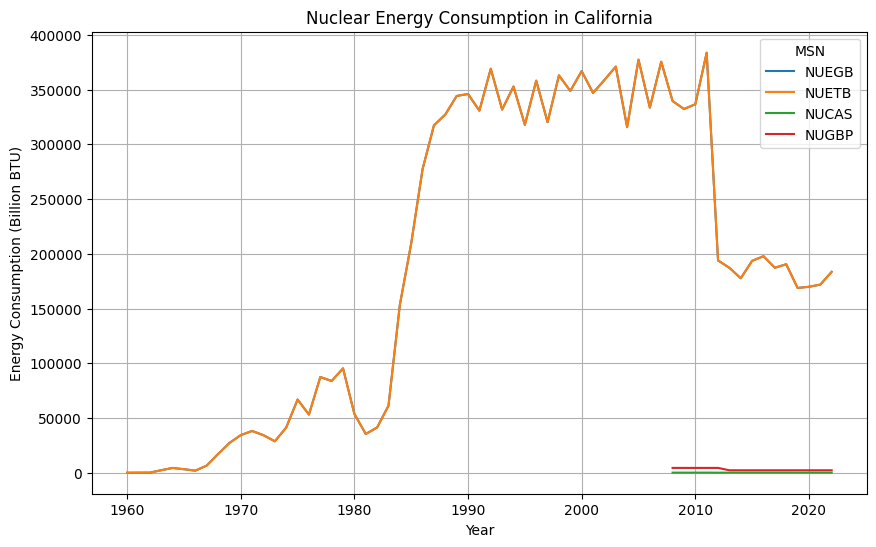

In [41]:
os.makedirs(r"C:\Code\energy-demand-forecasting\results", exist_ok=True)

state_data = nuclear_long[nuclear_long['State'] == 'CA']
plt.figure(figsize=(10, 6))
for msn in state_data['MSN'].unique():
    subset = state_data[state_data['MSN'] == msn]
    plt.plot(subset['Year'], subset['Energy_Consumption'], label=msn)

plt.title("Nuclear Energy Consumption in California")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend(title="MSN")
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuclear_california.png", dpi=300, bbox_inches="tight")

plt.show()

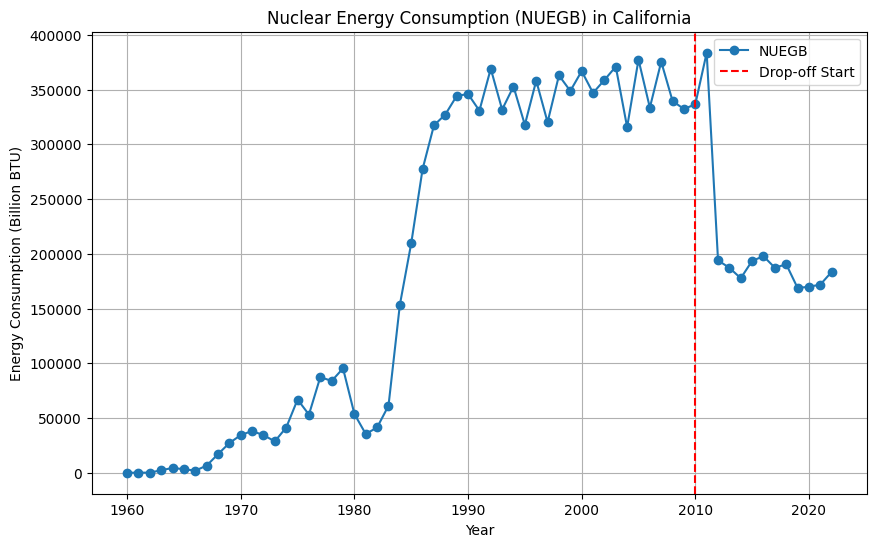

In [42]:
os.makedirs(r"C:\Code\energy-demand-forecasting\results", exist_ok=True)

# Focus on the MSN code 'NUEGB' for detailed analysis
nuegb_data = nuclear_long[(nuclear_long['State'] == 'CA') & (nuclear_long['MSN'] == 'NUEGB')]

# Plot the trend for NUEGB
plt.figure(figsize=(10, 6))
plt.plot(nuegb_data['Year'], nuegb_data['Energy_Consumption'], marker='o', label='NUEGB')

# Highlight drop-off points
plt.axvline(x=2010, color='red', linestyle='--', label='Drop-off Start')
plt.title("Nuclear Energy Consumption (NUEGB) in California")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend()
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuegb_california.png", dpi=300, bbox_inches="tight")

plt.show()


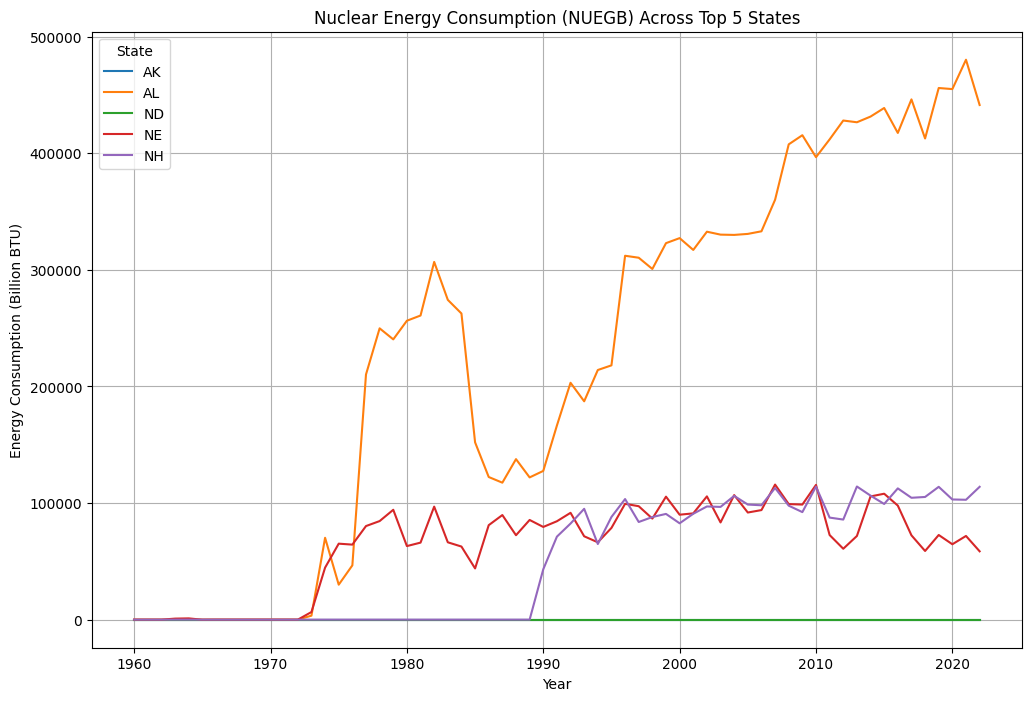

In [22]:
# Focus on NUEGB across all states
nuegb_all_states = nuclear_long[nuclear_long['MSN'] == 'NUEGB']

# Plot trends for the top 5 states with the most data
top_states = nuegb_all_states['State'].value_counts().head(5).index
plt.figure(figsize=(12, 8))
for state in top_states:
    state_data = nuegb_all_states[nuegb_all_states['State'] == state]
    plt.plot(state_data['Year'], state_data['Energy_Consumption'], label=state)

plt.title("Nuclear Energy Consumption (NUEGB) Across Top 5 States")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend(title="State")
plt.grid()
plt.show()


In [23]:
# Identify years with missing or zero values
missing_years = nuegb_data[nuegb_data['Energy_Consumption'] == 0]
print("Years with missing or zero consumption in California:")
print(missing_years)


Years with missing or zero consumption in California:
Empty DataFrame
Columns: [Data_Status, State, MSN, Description, Unit, Year, Energy_Consumption]
Index: []


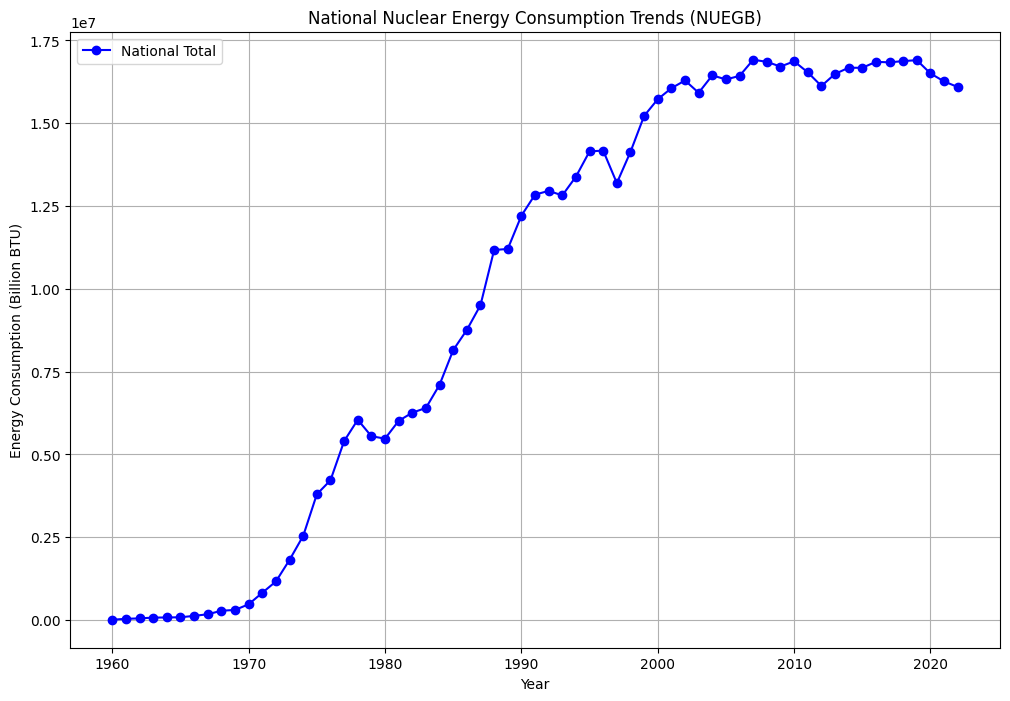

In [43]:
os.makedirs(r"C:\Code\energy-demand-forecasting\results", exist_ok=True)

# Sum nuclear energy consumption across all states for NUEGB
national_trends = nuclear_long[nuclear_long['MSN'] == 'NUEGB'].groupby('Year').sum()

# Plot national trends
plt.figure(figsize=(12, 8))
plt.plot(national_trends.index, national_trends['Energy_Consumption'], marker='o', color='blue', label='National Total')
plt.title("National Nuclear Energy Consumption Trends (NUEGB)")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend()
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuegb_national.png", dpi=300, bbox_inches="tight")

plt.show()


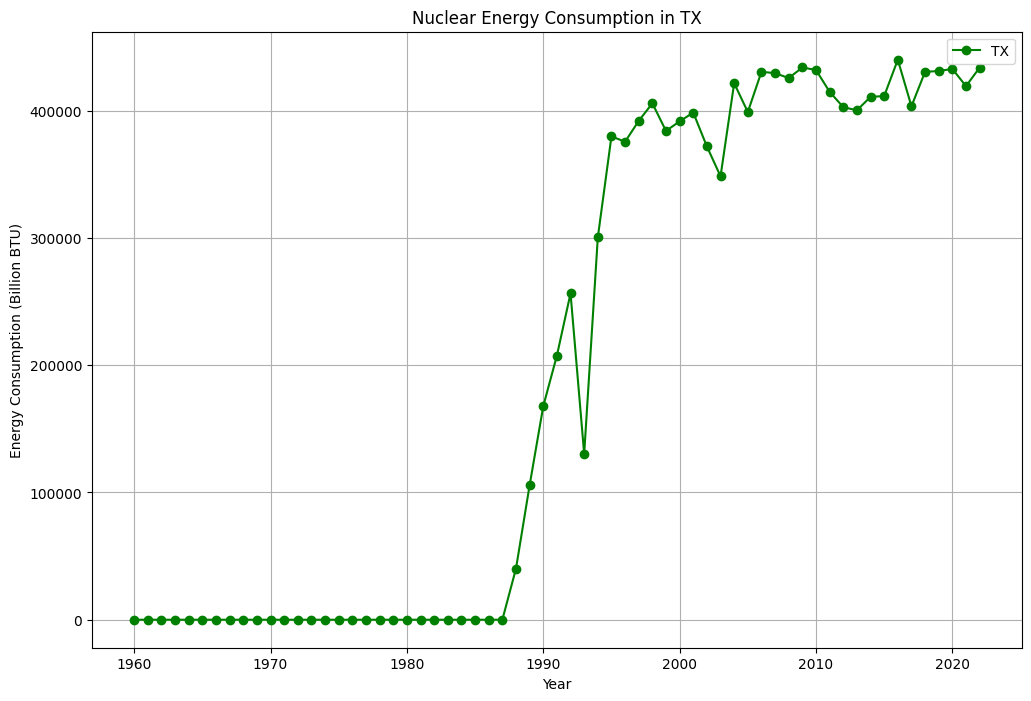

In [25]:
# Filter nuclear energy data for Texas (state code: TX)
state_code = 'TX'  # Replace 'TX' with the desired state code
state_data = nuclear_long[(nuclear_long['State'] == state_code) & (nuclear_long['MSN'] == 'NUEGB')]

# Plot trends for Texas
plt.figure(figsize=(12, 8))
plt.plot(state_data['Year'], state_data['Energy_Consumption'], marker='o', color='green', label=f'{state_code}')
plt.title(f"Nuclear Energy Consumption in {state_code}")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend()
plt.grid()
plt.show()


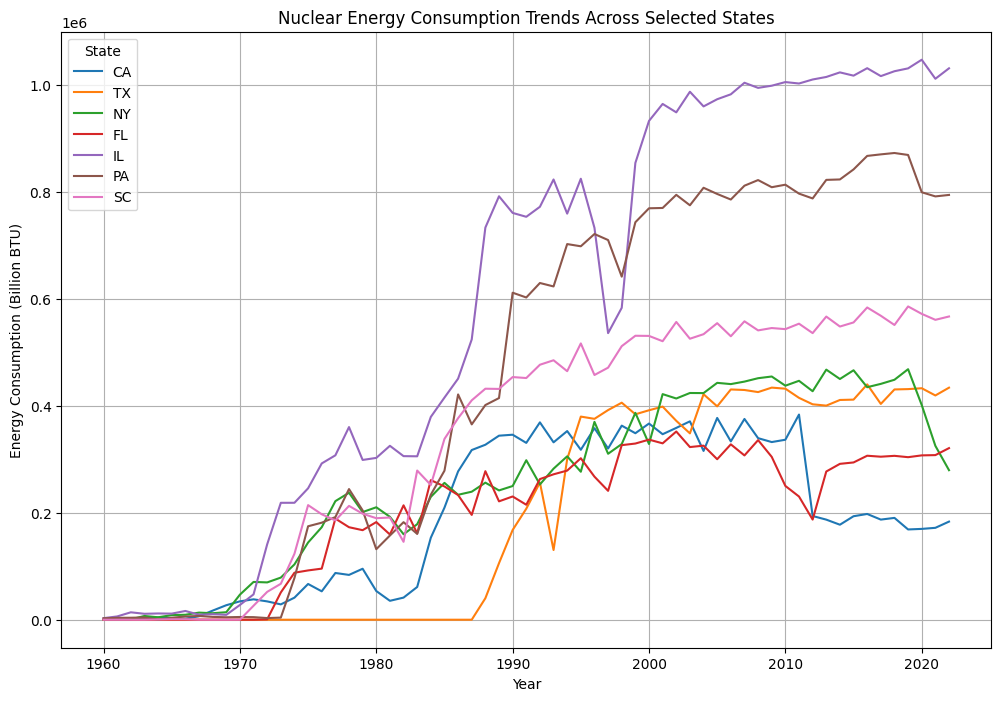

In [44]:
os.makedirs(r"C:\Code\energy-demand-forecasting\results", exist_ok=True)

# Compare trends for multiple states (e.g., CA, TX, NY, FL, IL, PA, SC)
selected_states = ['CA', 'TX', 'NY', 'FL', 'IL', 'PA', 'SC']
plt.figure(figsize=(12, 8))
for state in selected_states:
    state_data = nuclear_long[(nuclear_long['State'] == state) & (nuclear_long['MSN'] == 'NUEGB')]
    plt.plot(state_data['Year'], state_data['Energy_Consumption'], label=state)

plt.title("Nuclear Energy Consumption Trends Across Selected States")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend(title="State")
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuegb_selected_states.png", dpi=300, bbox_inches="tight")

plt.show()


In [27]:
# Total consumption by state for NUEGB
state_totals = nuclear_long[nuclear_long['MSN'] == 'NUEGB'].groupby('State')['Energy_Consumption'].sum().sort_values(ascending=False)
print("Top states for nuclear energy consumption:")
print(state_totals.head())


Top states for nuclear energy consumption:
State
US    313813565.0
IL     37208343.0
PA     29255343.0
SC     21836134.0
NY     16418788.0
Name: Energy_Consumption, dtype: float64


In [46]:
# Recreate the nuclear_long DataFrame
nuclear_long = pd.melt(
    merged_df[merged_df['Description'].str.contains('nuclear', case=False, na=False)],
    id_vars=['Data_Status', 'State', 'MSN', 'Description', 'Unit'],
    var_name='Year',
    value_name='Energy_Consumption'
)

# Ensure Year is numeric
nuclear_long['Year'] = pd.to_numeric(nuclear_long['Year'], errors='coerce')

# Drop rows with missing values in Energy_Consumption
nuclear_long = nuclear_long.dropna(subset=['Energy_Consumption'])

# Identify the top 5 states by total nuclear energy consumption
top_states = (
    nuclear_long[nuclear_long['MSN'] == 'NUEGB']
    .groupby('State')['Energy_Consumption']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)


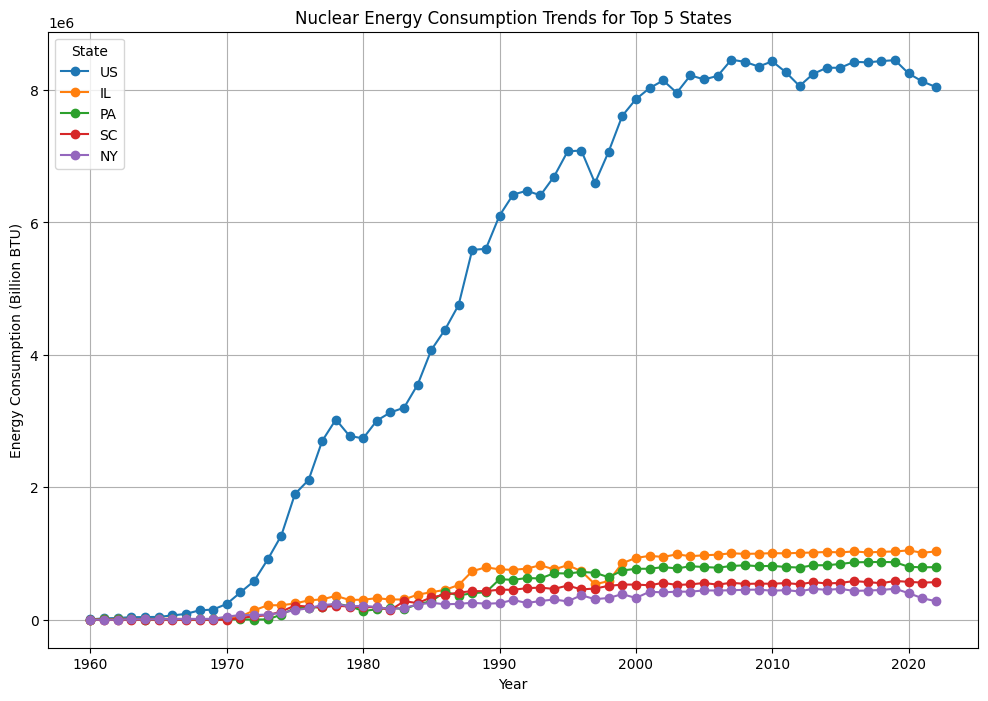

In [58]:
# Plot trends for the top 5 states
plt.figure(figsize=(12, 8))
for state in top_states:
    state_data = nuclear_long[(nuclear_long['State'] == state) & (nuclear_long['MSN'] == 'NUEGB')]
    plt.plot(state_data['Year'], state_data['Energy_Consumption'], marker='o', label=state)

plt.title("Nuclear Energy Consumption Trends for Top 5 States")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend(title="State")
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuegb_top5_states.png", dpi=300, bbox_inches="tight")

plt.show()

In [47]:
# Focus on national-level nuclear energy data for NUEGB
national_data = nuclear_long[nuclear_long['State'] == 'US']  # US is often used for national aggregates

# Ensure data is sorted by year
national_data = national_data[national_data['MSN'] == 'NUEGB'].sort_values('Year')

# Keep only Year and Energy_Consumption for simplicity
forecast_data = national_data[['Year', 'Energy_Consumption']].set_index('Year')

# Display the data to confirm structure
print(forecast_data.head())


      Energy_Consumption
Year                    
1960              6026.0
1961             19678.0
1962             26394.0
1963             38147.0
1964             39819.0


In [48]:
# Filter for national-level data starting from 1960
national_data_1960 = nuclear_long[
    (nuclear_long['State'] == 'US') & 
    (nuclear_long['Year'] >= 1960) & 
    (nuclear_long['MSN'] == 'NUEGB')
].sort_values('Year')

# Keep only Year and Energy_Consumption
forecast_data_1960 = national_data_1960[['Year', 'Energy_Consumption']].set_index('Year')

# Display the filtered data
print(forecast_data_1960.head())


      Energy_Consumption
Year                    
1960              6026.0
1961             19678.0
1962             26394.0
1963             38147.0
1964             39819.0


In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Train-test split
train_1960 = forecast_data_1960.iloc[:-5]  # Use all but the last 5 years as training
test_1960 = forecast_data_1960.iloc[-5:]   # Use the last 5 years as testing

# Apply Exponential Smoothing
model_1960 = ExponentialSmoothing(train_1960, trend="add", seasonal=None, damped_trend=True).fit()

# Forecast the next 5 years
forecast_1960 = model_1960.forecast(steps=5)



C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a

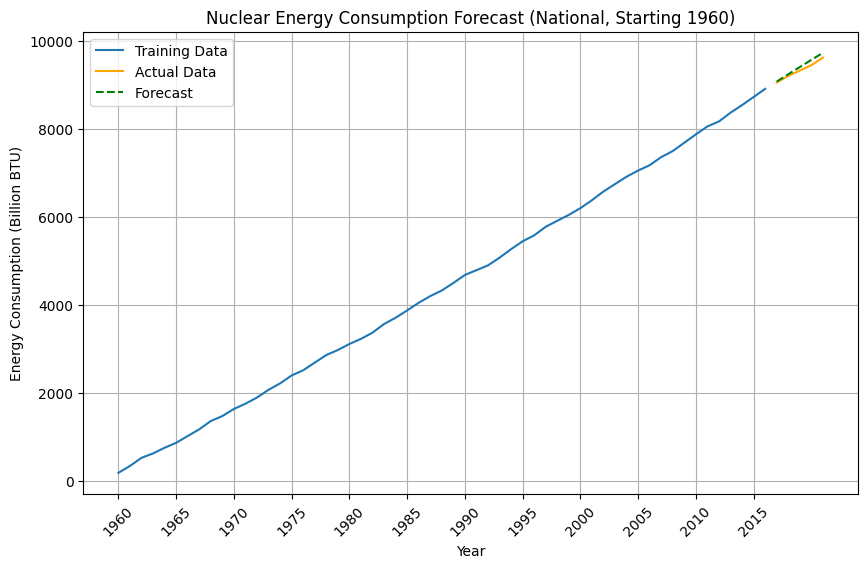

In [63]:
os.makedirs(r"C:\Code\energy-demand-forecasting\results", exist_ok=True)

# Correct Year handling and plot
plt.figure(figsize=(10, 6))
plt.plot(train_1960.index, train_1960['Energy_Consumption'], label='Training Data')
plt.plot(test_1960.index, test_1960['Energy_Consumption'], label='Actual Data', color='orange')
plt.plot(test_1960.index, forecast_1960, label='Forecast', color='green', linestyle='--')

plt.title("Nuclear Energy Consumption Forecast (National, Starting 1960)")
plt.xlabel("Year")
plt.xticks(train_1960.index[::5], rotation=45)  # Adjust year ticks for readability
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend()
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuegb_forecast_1960.png", dpi=300, bbox_inches="tight")

plt.show()

In [50]:
mae_1960 = mean_absolute_error(test_1960, forecast_1960)
rmse_1960 = np.sqrt(mean_squared_error(test_1960, forecast_1960))

print(f"Mean Absolute Error (MAE): {mae_1960}")
print(f"Root Mean Square Error (RMSE): {rmse_1960}")



Mean Absolute Error (MAE): 244128.93164991325
Root Mean Square Error (RMSE): 316787.58891509863


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=568.271, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=554.206, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=566.280, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=551.870, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=548.894, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=547.741, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=546.193, Time=0.08 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=544.569, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=545.961, Time=0.05 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=535.304, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=535.290, Time=0.06 se

C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


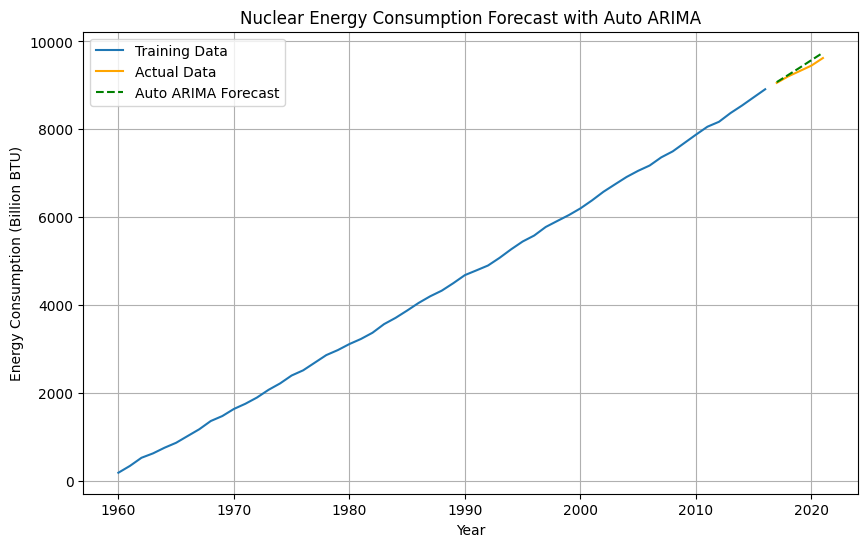

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(3, 2, 1)   Log Likelihood                -262.382
Date:                Tue, 23 Sep 2025   AIC                            534.764
Time:                        08:59:49   BIC                            544.801
Sample:                             0   HQIC                           538.645
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1435      0.167     -0.857      0.392      -0.472       0.185
ar.L2         -0.1415      0.164     -0.864      0.387      -0.462       0.179
ar.L3         -0.2105      0.156     -1.352      0.176      -0.516       0.095
ma.L1         -0.8833      0.109     -8.075      0.000      -1.098      -0.669
sigma2       781.2923    239.816      3.258      0.001     311.261    1251.324
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 3.31
Prob(Q):                              0.58   Prob(JB):                         0.19
Heteroskedasticity (H):               0.93   Skew:                            -0.34
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# Automatically find the best ARIMA parameters for the training data
auto_arima_model = auto_arima(
    train_1960,              # Training data
    seasonal=False,          # Assume no seasonality
    stepwise=True,           # Use a stepwise search to find the best parameters
    suppress_warnings=True,  # Suppress warnings for better readability
    error_action="ignore",   # Ignore errors for edge cases
    trace=True               # Show the parameter search process
)

# Forecast the next 5 years
auto_arima_forecast = auto_arima_model.predict(n_periods=5)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_1960, label="Training Data")
plt.plot(test_1960, label="Actual Data", color="orange")
plt.plot(test_1960.index, auto_arima_forecast, label="Auto ARIMA Forecast", color="green", linestyle="--")
plt.title("Nuclear Energy Consumption Forecast with Auto ARIMA")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend()
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuegb_auto_arima_forecast.png", dpi=300, bbox_inches="tight")

plt.show()

# Print the summary of the Auto ARIMA model
auto_arima_model.summary()


In [52]:
# Create lagged features for supervised learning
def create_lagged_features(data, lags=3):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f"Lag_{lag}"] = df['Energy_Consumption'].shift(lag)
    df.dropna(inplace=True)  # Remove rows with NaN values caused by lagging
    return df

# Prepare the dataset
ml_data = create_lagged_features(forecast_data_1960, lags=3)

# Split into training and testing sets
X_train = ml_data.iloc[:-5, 1:]  # Lagged features
y_train = ml_data.iloc[:-5, 0]   # Target variable
X_test = ml_data.iloc[-5:, 1:]
y_test = ml_data.iloc[-5:, 0]


XGBoost - MAE: 437.913671875, RMSE: 479.24756025987773


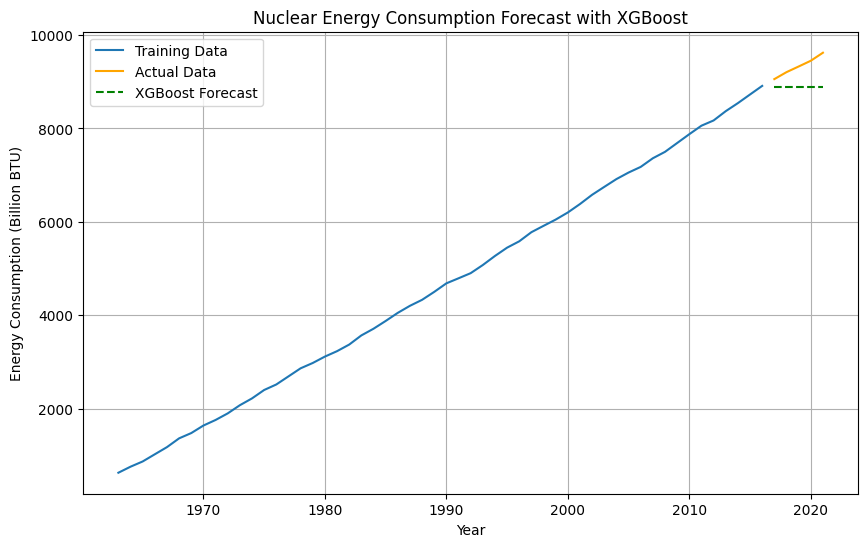

In [66]:
# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_forecast = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, xgb_forecast)
rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))
print(f"XGBoost - MAE: {mae}, RMSE: {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ml_data.index[:-5], y_train, label="Training Data")
plt.plot(ml_data.index[-5:], y_test, label="Actual Data", color="orange")
plt.plot(ml_data.index[-5:], xgb_forecast, label="XGBoost Forecast", color="green", linestyle="--")
plt.title("Nuclear Energy Consumption Forecast with XGBoost")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend()
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuegb_xgboost_forecast.png", dpi=300, bbox_inches="tight")

plt.show()


Random Forest - MAE: 107837.08999999985, RMSE: 122413.8852865376


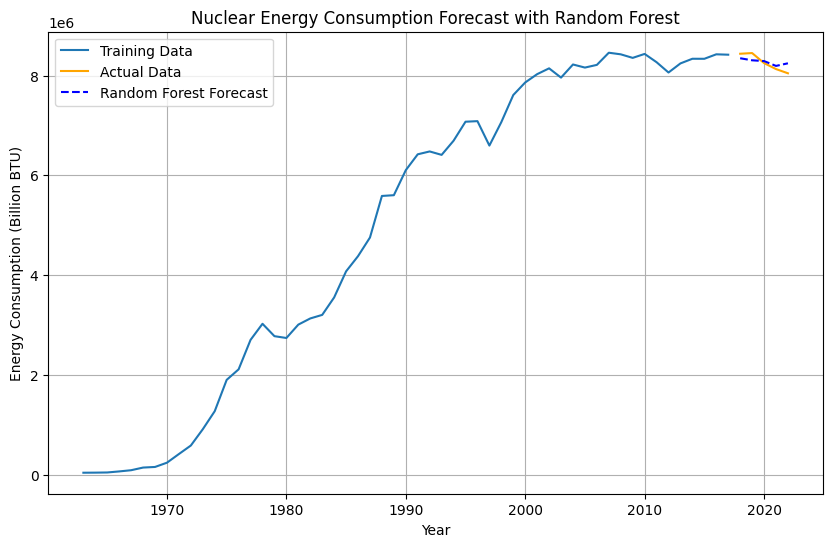

In [54]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_forecast = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, rf_forecast)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_forecast))
print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ml_data.index[:-5], y_train, label="Training Data")
plt.plot(ml_data.index[-5:], y_test, label="Actual Data", color="orange")
plt.plot(ml_data.index[-5:], rf_forecast, label="Random Forest Forecast", color="blue", linestyle="--")
plt.title("Nuclear Energy Consumption Forecast with Random Forest")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend()
plt.grid()
plt.show()


XGBoost - MAE: 24431.3625, RMSE: 28839.491318451357
Random Forest - MAE: 15493.059999999998, RMSE: 18636.512080368473


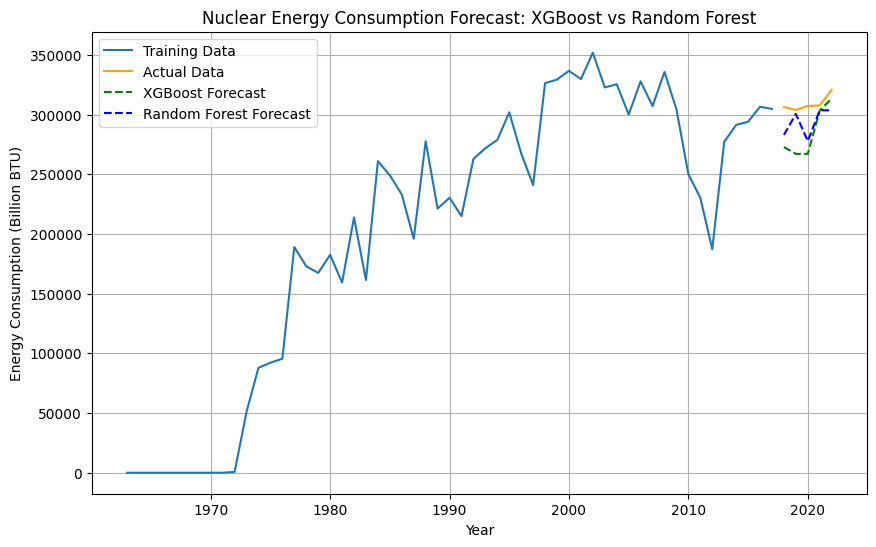

In [67]:
# Recreate national_data_1960 to define the dataset properly
national_data_1960 = nuclear_long[
    (nuclear_long['State'] == 'FL') & 
    (nuclear_long['Year'] >= 1960) & 
    (nuclear_long['MSN'] == 'NUEGB')
].sort_values('Year')

# Extract only the necessary columns
forecast_data_1960 = national_data_1960[['Year', 'Energy_Consumption']].set_index('Year')

# Recreate the lagged features and split the data
ml_data = create_lagged_features(forecast_data_1960, lags=3)

# Split into training and testing sets
X_train = ml_data.iloc[:-5, 1:]  # Lagged features
y_train = ml_data.iloc[:-5, 0]   # Target variable
X_test = ml_data.iloc[-5:, 1:]
y_test = ml_data.iloc[-5:, 0]

# Retrain and compare XGBoost and Random Forest models
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Forecast with XGBoost
xgb_forecast = xgb_model.predict(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Forecast with Random Forest
rf_forecast = rf_model.predict(X_test)

# Evaluate models
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))
rf_mae = mean_absolute_error(y_test, rf_forecast)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_forecast))

print(f"XGBoost - MAE: {xgb_mae}, RMSE: {xgb_rmse}")
print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}")

# Plot results for comparison
plt.figure(figsize=(10, 6))
plt.plot(ml_data.index[:-5], y_train, label="Training Data")
plt.plot(ml_data.index[-5:], y_test, label="Actual Data", color="orange")
plt.plot(ml_data.index[-5:], xgb_forecast, label="XGBoost Forecast", color="green", linestyle="--")
plt.plot(ml_data.index[-5:], rf_forecast, label="Random Forest Forecast", color="blue", linestyle="--")
plt.title("Nuclear Energy Consumption Forecast: XGBoost vs Random Forest")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (Billion BTU)")
plt.legend()
plt.grid()

# Save chart
plt.savefig(r"C:\Code\energy-demand-forecasting\results\nuegb_xgb_vs_rf_forecast.png", dpi=300, bbox_inches="tight")

plt.show()


In [56]:
# Calculate Mean Absolute Percentage Error (MAPE) for XGBoost and Random Forest
mape_xgb = (xgb_mae / y_test.mean()) * 100
mape_rf = (rf_mae / y_test.mean()) * 100

# Print MAPE results
print(f"XGBoost MAPE: {mape_xgb:.2f}%")
print(f"Random Forest MAPE: {mape_rf:.2f}%")


XGBoost MAPE: 7.90%
Random Forest MAPE: 5.01%


In [57]:
# Recreate necessary functions and data
def create_lagged_features(data, lags=3):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f"Lag_{lag}"] = df['Energy_Consumption'].shift(lag)
    df.dropna(inplace=True)
    return df

# Placeholder for forecast_data_1960, replace with actual data loading code
# Simulated dummy data for context since the environment was reset
years = pd.date_range(start='1960', periods=62, freq='Y')
energy_consumption = np.cumsum(np.random.randint(100, 200, size=62))  # Simulated growth data
forecast_data_1960 = pd.DataFrame({'Energy_Consumption': energy_consumption}, index=years.year)

# Prepare the data for machine learning
ml_data = create_lagged_features(forecast_data_1960, lags=3)

# Split into training and testing sets
X_train = ml_data.iloc[:-5, 1:]
y_train = ml_data.iloc[:-5, 0]
X_test = ml_data.iloc[-5:, 1:]
y_test = ml_data.iloc[-5:, 0]

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)

# Calculate MAE for both models
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
rf_mae = mean_absolute_error(y_test, rf_forecast)

# Calculate MAPE for XGBoost and Random Forest
mape_xgb = (xgb_mae / y_test.mean()) * 100
mape_rf = (rf_mae / y_test.mean()) * 100

# Print MAPE results
print(f"XGBoost MAPE: {mape_xgb:.2f}%")
print(f"Random Forest MAPE: {mape_rf:.2f}%")


XGBoost MAPE: 4.69%
Random Forest MAPE: 5.55%


C:\Users\mathe\AppData\Local\Temp\ipykernel_20172\3745301017.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years = pd.date_range(start='1960', periods=62, freq='Y')
